
# Measure AUC on Test Dataset for IML Challenge

This notebook extracts the AUC of your method measured on the test dataset. Please read the challenge instructions for further information.

## Set up TMVA

In [45]:
import ROOT

# Set up TMVA reader
reader = ROOT.TMVA.Reader("Color:!Silent")

## Load data

**NOTE:** You have to preprocess the modified data, similar to what was done for the "standard" data in the TMVAClassification notebook.   
In order to do that, please run `sh PREPROCESS_DATA_MODIFIED` in a terminal.


In [46]:
# NOTE: Check out the `preprocess_data.py` script shipped with this notebook!

#nE = 500000
mName = 'BDTM'

data = ROOT.TFile("/eos/user/m/mlisovyi/cernbox/IML_tutorial/data/preprocessed4TMVA_mod.root")
#data = ROOT.TFile("preprocessed_data_modified.root")
if data == None:
    raise Exception('Have you run the preprocessing? Can not open file: {}'.format(filename))

quarks = data.Get('quarks')
gluons = data.Get('gluons')

nEQ = quarks.GetEntries()
nEG = gluons.GetEntries()

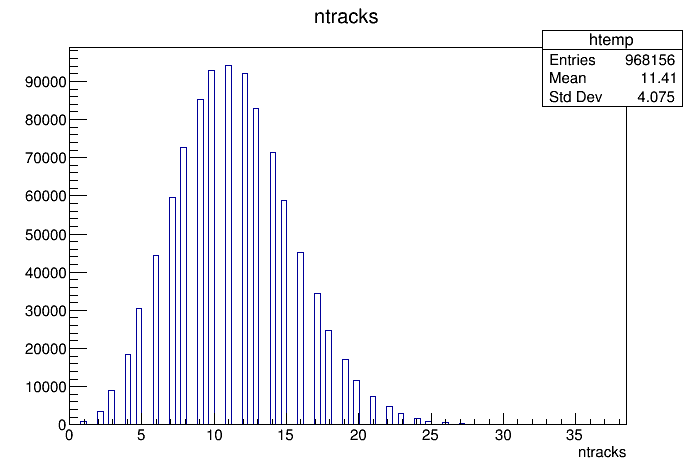

In [47]:

gluons.Draw("ntracks","","",nEG)
ROOT.gPad.Draw()

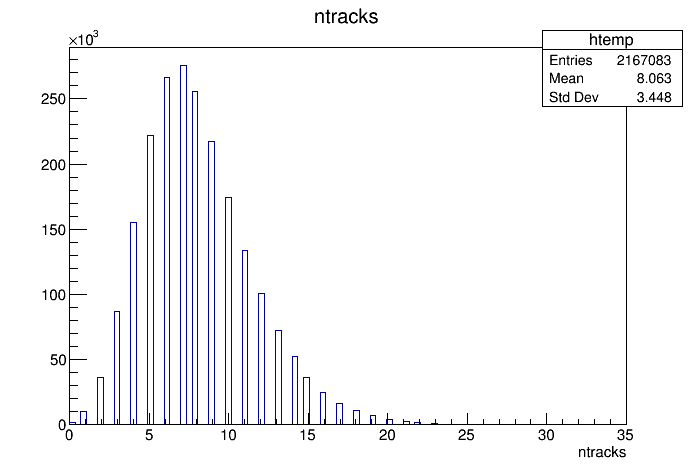

In [48]:

quarks.Draw("ntracks","","",nEQ)
ROOT.gPad.Draw()

## Declare variables

You have to declare which variables you want to use for the application.

In [49]:
from array import array

branches = {}
for branch in quarks.GetListOfBranches():
    branchName = branch.GetName()
    if not '_' in branchName : # NOTE: This selection has to be the same as used during training!
    #if branchName in ['jetPt', 'jetEta', 'jetPhi', 'jetMass', 'ntracks', 'ntowers'] :
        branches[branchName] = array('f', [-999])
        reader.AddVariable(branchName, branches[branchName])
        quarks.SetBranchAddress(branchName, branches[branchName])
        gluons.SetBranchAddress(branchName, branches[branchName])

## Book method

Point here to the weight file of the method you want to use.

In [50]:
# Book method
inStr= 'ml_v0_'+mName+'.weights.xml'
print inStr

ml_v0_BDTM.weights.xml


In [51]:
reader.BookMVA(mName, ROOT.TString(inStr))

<ROOT.TMVA::MethodBDT object ("BDTM") at 0x638e760>

                         : Booking "BDTM" of type "BDT" from ml_v0_BDTM.weights.xml.
DataSetInfo              : [Default] : Added class "quarks"
DataSetInfo              : [Default] : Added class "gluons"
                         : Booked classifier "BDTM" of type: "BDT"


## Classify data

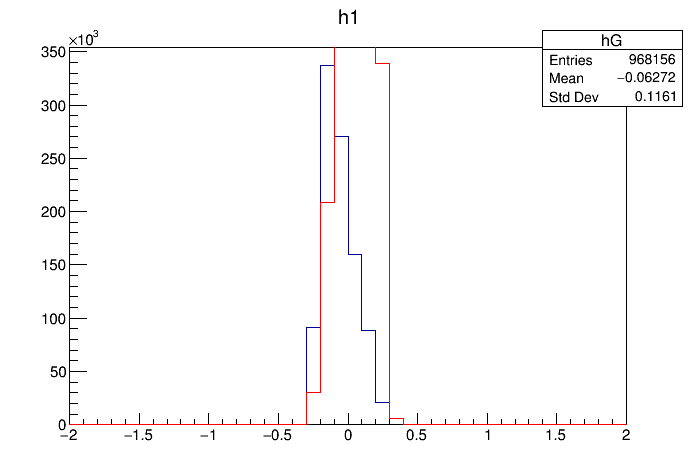

In [52]:
import numpy as np

hQ = ROOT.TH1F("hQ","h1",40,-2,2)
hG = ROOT.TH1F("hG","h1",40,-2,2)

# Classify quarks
#mvaValues_quarks = np.zeros(quarks.GetEntries())
#for i in range(quarks.GetEntries()):
mvaValues_quarks = np.zeros(nEQ)
for i in range(nEQ):
    quarks.GetEntry(i)
    mvaValues_quarks[i] = reader.EvaluateMVA(mName)
    hQ.Fill(mvaValues_quarks[i])

# Classify
#mvaValues_gluons = np.zeros(gluons.GetEntries())
#for i in range(gluons.GetEntries()):
mvaValues_gluons = np.zeros(nEG)
for i in range(nEG):
    gluons.GetEntry(i)
    mvaValues_gluons[i] = reader.EvaluateMVA(mName)
    hG.Fill(mvaValues_gluons[i])

    
hG.Draw()
hQ.SetLineColor(2)
hQ.Draw("same")
ROOT.gPad.Draw()

## Calculate area-under-curve (AUC)

In [53]:
from sklearn import metrics

# Calculate ROC
#y_true = np.hstack((np.ones(quarks.GetEntries()), np.zeros(gluons.GetEntries())))
y_true = np.hstack((np.ones(nEQ), np.zeros(nEG)))
y_score = np.hstack((mvaValues_quarks, mvaValues_gluons))
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)

# Get AUC from ROC
auc = metrics.auc(fpr, tpr)
print('{0} AUC: {1}'.format(mName, auc))
print "Done"

BDTM AUC: 0.784747820601
Done


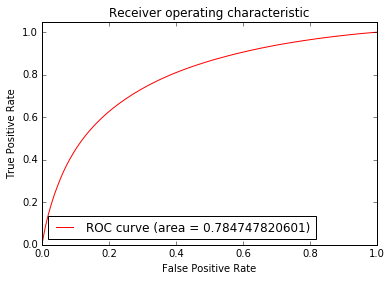

In [54]:
# Plot ROC

import matplotlib.pyplot as plt
# Enable Javascript magic for matplotlib
%matplotlib inline

plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = {})'.format(auc))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=0)
plt.show()

In [57]:
# Save AUC value
f = open("ml_vX_auc.txt","w") 
f.write(str(auc))
f.close()
print auc

0.784747820601
